In [1]:
# -------- Imports --------
import sys
import os
import numpy as np
import scipy.sparse as sp
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from _utility import *


In [2]:
# -------- Functions --------
def FD(dx, Nx):
    """Finite Difference operator for first derivative. First order accurate. All DBC."""
    return (1 / dx) * sp.diags([1, -1], [0, -1], shape=(Nx, Nx), format='lil')[:, :-1]


In [3]:
# -------- Parameters --------
# -- Grid parameters --
Nx, Ny, Nz  = 30, 30, 30
dx, dy, dz = 1.0, 1.0, 1.0
bcs = {'L': 'DBC', 'R': 'DBC', 'T': 'DBC', 'B': 'DBC', 'F': 'DBC', 'Ba': 'DBC'}

# -- Simulation parameters --
Nt = 100
dt = 0.1

# -- Initial Conditions --
# Electric field x (Ex)
lambda_wave = 10.0              # Wavelength
k = 2 * np.pi / lambda_wave     # Wave number
z = np.arange(Nz) * dz
E0 = 1.0                        # Electric field amplitude
Ex0 = E0 * np.cos(k * z).reshape(Nz, 1, 1) * np.ones((Nz, Ny, Nx)) # Plane wave

# Electric field y (Ey)
Ey0 = np.zeros((Nz, Ny, Nx))

# Electric field z (Ez)
Ez0 = np.zeros((Nz, Ny, Nx))

# Magnetic field x (Hx)
Hx0 = np.zeros((Nz, Ny, (Nx-1)))

# Magnetic field y (Hy)
H0 = E0 / 1.0  # Since c = 1.0, H0 = E0 / c = E0
Hy0 = H0 * np.cos(k * z).reshape(Nz, 1, 1) * np.ones((Nz, Ny-1, Nx)) # Plane wave

# Magnetic field z (Hz)
Hz0 = np.zeros(((Nz-1), Ny, Nx))

# -- Material properties --
# Permittivity (eps)
eps0 = 1
eps_model_x = eps0 * np.ones((Nz, Ny, Nx))
eps_model_y = eps0 * np.ones((Nz, Ny, Nx))
eps_model_z = eps0 * np.ones((Nz, Ny, Nx))

# Permeability (mu)
mu0 = 1
mu_stag_x = mu0 * np.ones((Nz, Ny, (Nx-1)))
mu_stag_y = mu0 * np.ones((Nz, (Ny-1), Nx))
mu_stag_z = mu0 * np.ones(((Nz-1), Ny, Nx))


In [4]:
# -------- Validity Checks --------
# -- Divergence free E-field  --
div_E = (np.gradient(Ex0, dx, axis=2) +
         np.gradient(Ey0, dy, axis=1) +
         np.gradient(Ez0, dz, axis=0))
print('Divergence-free E:', np.allclose(div_E, 0))

# -- Divergence free H-field (approximation) --
div_H = (np.gradient(Hx0[:-1,:-1,:], dx, axis=2) +
         np.gradient(Hy0[:-1,:,:-1], dy, axis=1) +
         np.gradient(Hz0[:,:-1,:-1], dz, axis=0))
print('Divergence-free H:', np.allclose(div_H, 0))


Divergence-free E: True
Divergence-free H: True


In [5]:
# -------- Matrix A (Maxwells) --------
# Finite difference operators
FD_x = FD(dx, Nx)
FD_y = FD(dy, Ny)
FD_z = FD(dz, Nz)

# Boundary conditions (Dirichlet or Neumann)
if bcs['L'] == 'NBC': FD_x[0, :] = 0 
if bcs['R'] == 'NBC': FD_x[-1, :] = 0
if bcs['F'] == 'NBC': FD_y[0, :] = 0 
if bcs['Ba'] == 'NBC': FD_y[-1, :] = 0
if bcs['T'] == 'NBC': FD_z[0, :] = 0
if bcs['B'] == 'NBC': FD_z[-1, :] = 0

# Derivative operators
D_x = sp.kron(FD_x, sp.kron(sp.eye(Ny), sp.eye(Nz)), format='csr')
D_y = sp.kron(sp.eye(Nx), sp.kron(FD_y, sp.eye(Nz)), format='csr')
D_z = sp.kron(sp.eye(Nx), sp.kron(sp.eye(Ny), FD_z), format='csr')

# Curl operator
Curl = sp.bmat([
    [None, -D_z, D_y],
    [D_z, None, -D_x],
    [-D_y, D_x, None]
], format='csr')

# System matrix A
A = sp.bmat([
    [None, Curl],
    [-Curl.T, None]
], format='csr')


In [6]:
# -------- Matrix B (Maxwells) --------
# Flatten the arrays
eps_model_x = eps_model_x.flatten()
eps_model_y = eps_model_y.flatten()
eps_model_z = eps_model_z.flatten()
mu_stag_x = mu_stag_x.flatten()
mu_stag_y = mu_stag_y.flatten()
mu_stag_z = mu_stag_z.flatten()

# Material matrices for E and H (sqrt)
B_Ex_sqrt = sp.diags(np.sqrt(eps_model_x), format='csr')
B_Ey_sqrt = sp.diags(np.sqrt(eps_model_y), format='csr')
B_Ez_sqrt = sp.diags(np.sqrt(eps_model_z), format='csr')
B_Hx_sqrt = sp.diags(np.sqrt(mu_stag_x), format='csr')
B_Hy_sqrt = sp.diags(np.sqrt(mu_stag_y), format='csr')
B_Hz_sqrt = sp.diags(np.sqrt(mu_stag_z), format='csr')
B_sqrt = sp.block_diag([B_Ex_sqrt, B_Ey_sqrt, B_Ez_sqrt, 
                        B_Hx_sqrt, B_Hy_sqrt, B_Hz_sqrt], format='csr')

# Material matrices for E and H (sqrt_inv)
B_Ex_inv_sqrt = sp.diags(1 / np.sqrt(eps_model_x), format='csr')
B_Ey_inv_sqrt = sp.diags(1 / np.sqrt(eps_model_y), format='csr')
B_Ez_inv_sqrt = sp.diags(1 / np.sqrt(eps_model_z), format='csr')
B_Hx_inv_sqrt = sp.diags(1 / np.sqrt(mu_stag_x), format='csr')
B_Hy_inv_sqrt = sp.diags(1 / np.sqrt(mu_stag_y), format='csr')
B_Hz_inv_sqrt = sp.diags(1 / np.sqrt(mu_stag_z), format='csr')
B_inv_sqrt = sp.block_diag([B_Ex_inv_sqrt, B_Ey_inv_sqrt, B_Ez_inv_sqrt, 
                            B_Hx_inv_sqrt, B_Hy_inv_sqrt, B_Hz_inv_sqrt], format='csr')


In [7]:
# -------- Hamiltonian (Maxwells) --------
H = 1j * B_inv_sqrt @ A @ B_inv_sqrt
print('Hermitian:', not (H - H.conj().T).nnz)
print('Hamiltonian Size:', H.shape)


Hermitian: True
Hamiltonian Size: (159300, 159300)


In [ ]:
# -------- Initial State  --------
# Stack the initial conditions
phi_0 = np.hstack([Ex0.flatten(), Ey0.flatten(), Ez0.flatten(), 
                  Hx0.flatten(), Hy0.flatten(), Hz0.flatten()])

# Normalize the initial state and transform it to the energy basis
psi_0 = B_sqrt @ phi_0
norm = np.linalg.norm(psi_0)
psi_0 /= norm


In [9]:
# -------- Time Evolution --------
# Evolve the state over time (energy basis)
psi_t = sp.linalg.expm_multiply(-1j * H, psi_0, start=0, stop=Nt*dt, num=Nt, endpoint=True).real


In [10]:
# -------- Final State --------
# Transform the state back to the original basis
phi_t = norm * (B_inv_sqrt @ psi_t.T).T


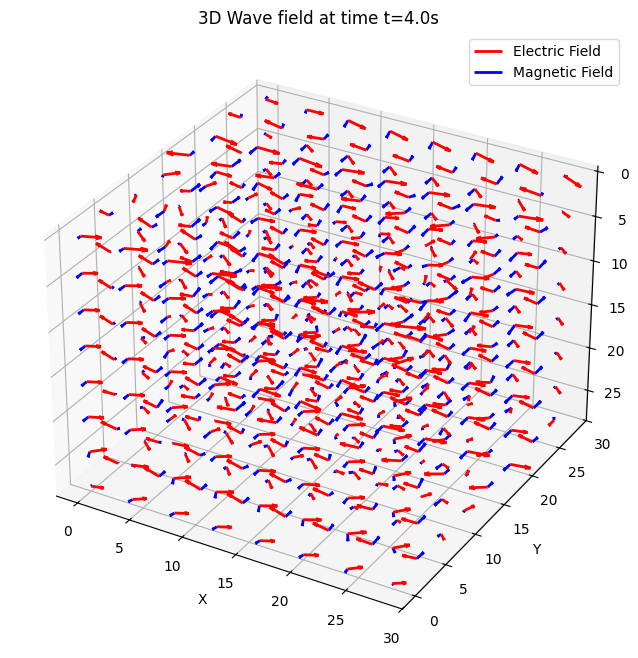

In [11]:
# -------- Plot --------
t_plot = 40
plot_maxwells_3D(phi_t[t_plot], Nx, Ny, Nz, dx, dy, dz, title=f'3D Wave field at time t={t_plot*dt}s')


In [12]:
# -------- Total Energy Conservation --------
N = Nx * Ny * Nz # Number of grid points
V = dx * dy * dz # Volume of each grid cell

EN0 = (1/2) * np.linalg.norm(B_sqrt @ phi_0)**2 * V * N
print('Initial Energy:', EN0.round(4))

ENT = (1/2) * np.linalg.norm(B_sqrt @ phi_t.T, axis=0)**2 * V * N
print('Final Energy:', ENT[-1].round(4))


Initial Energy: 358425000.0
Final Energy: 358425000.0
